**VIS + NIR tutorial** 

For dual VIS/NIR workflows, a visible image is used to identify an image mask for the plant material. We use a landmark transformation to place the VIS image mask over the NIR image. This allows two workflows to be done at once and also allows plant material to be identified in low-quality images. We do not recommend this approach if there is a lot of plant movement between capture of NIR and VIS images.

Updated July 2025.

In [1]:
import os

# Detect notebook environment
def detect_notebook_environment():
    if 'COLAB_GPU' in os.environ:
        print('Google Colaboratory detected.')
        %pip install "altair>=5" ipympl plantcv
        
        # Give access and mount your Google Drive (need a Google Account)
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        # Enable widget feature with matplotlib
        from google.colab import output
        output.enable_custom_widget_manager()
        
        #View working directory, may need to change
        %pwd
    else:
        print('Binder detected.')

environment = detect_notebook_environment()

Binder detected.


In [2]:
# Import the needed packages needed to run 

%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs


In [3]:
# Import a sample image and define it to be used in the notebook
# for parallelization with multiple images see documentation of groupby and group_name
# fields of the configuration json.
args = WorkflowInputs(
    images=["./sample_images/VIS_SV_0_z1_h1_g0_e77_v500_84572_0.png",
            "./sample_images/NIR_SV_0_z1_h1_g0_e21500_v500_84575_0.png"],
    names="vis,nir",
    result="data_output.json",
    outdir="img_output",
    writeimg=False,
    debug="plot"
)


In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug

# Change the display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.debug_outdir = args.outdir

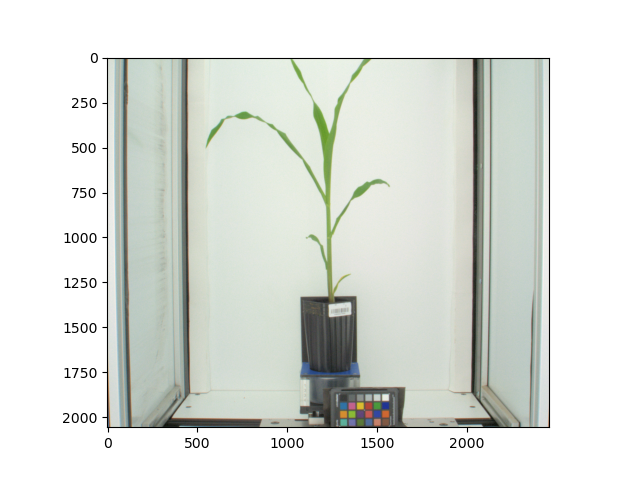

In [5]:
# Read VIS image 

# Filename - Image file to be read in  
img, path, filename = pcv.readimage(filename=args.vis)

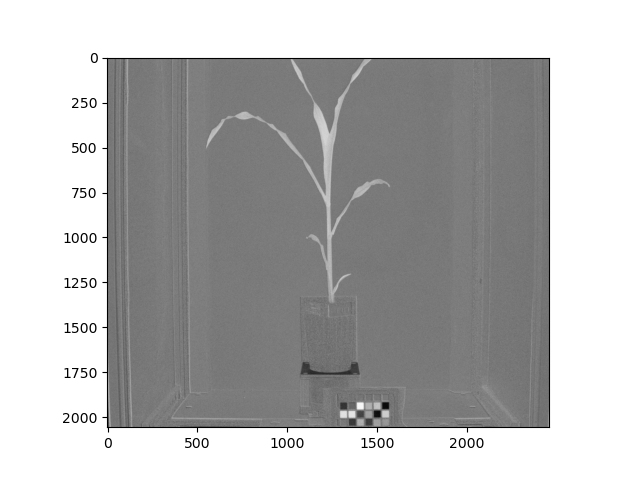

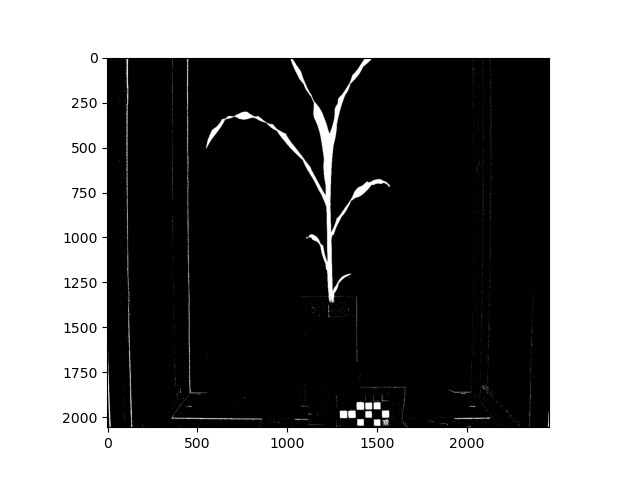

In [6]:
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
thresh = pcv.threshold.binary(gray_img=b, threshold=145, object_type='light')

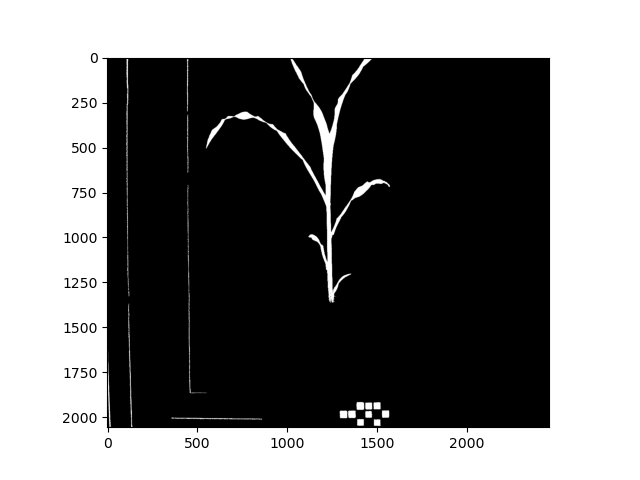

In [7]:
filled_mask = pcv.fill(bin_img=thresh, size=1000)

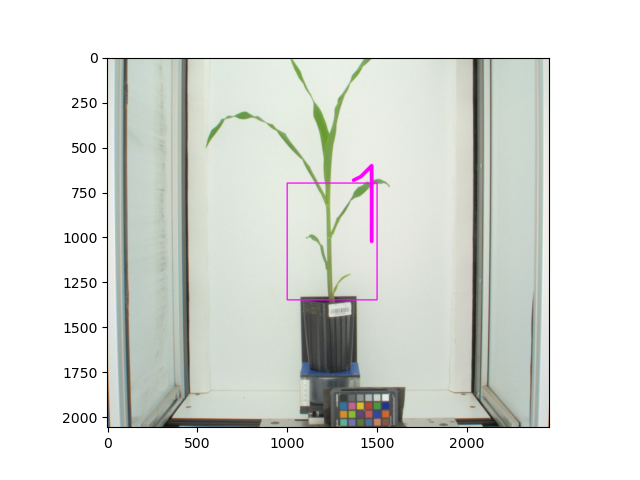

In [8]:
roi = pcv.roi.rectangle(img=img, x=1000, y=700, h=650, w=500)

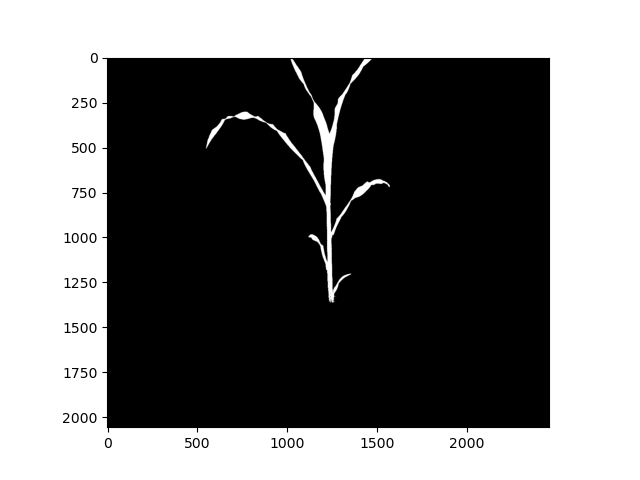

In [9]:
# Filter binary image to make a clean mask
mask = pcv.roi.quick_filter(mask=filled_mask, roi=roi)

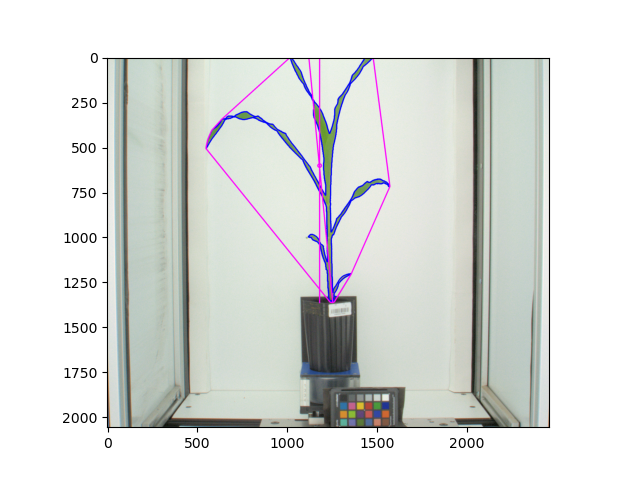

alt.FacetChart(...)

In [10]:
############### VIS (RGB) Analysis ################ 
analysis_image = pcv.analyze.size(img=img, labeled_mask=mask, label="default")
color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=mask, label="default")

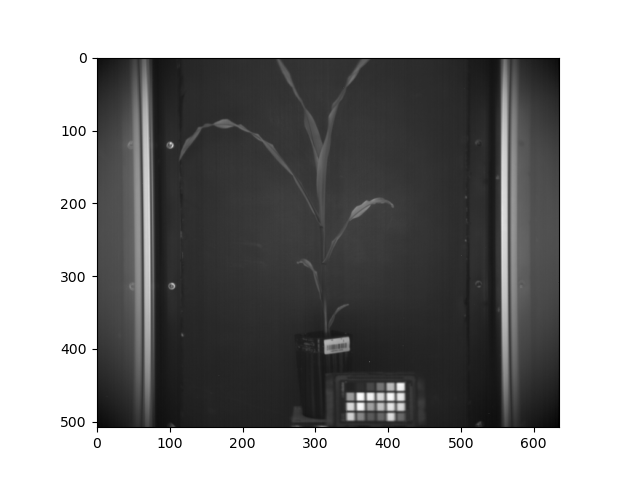

In [11]:
# Read in NIR image
nir, path1, filename1 = pcv.readimage(filename=args.nir, mode='native')

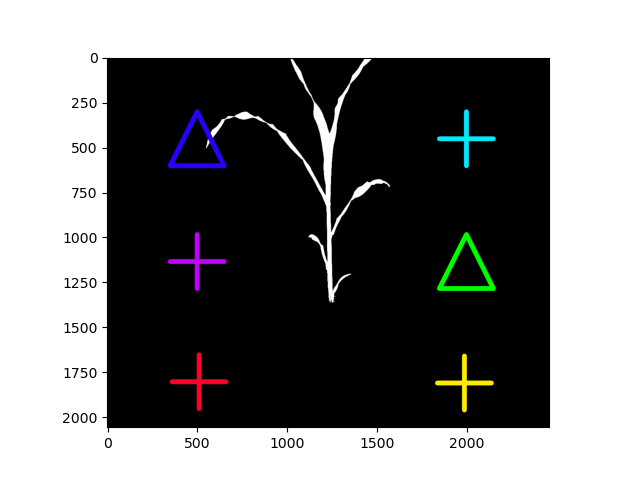

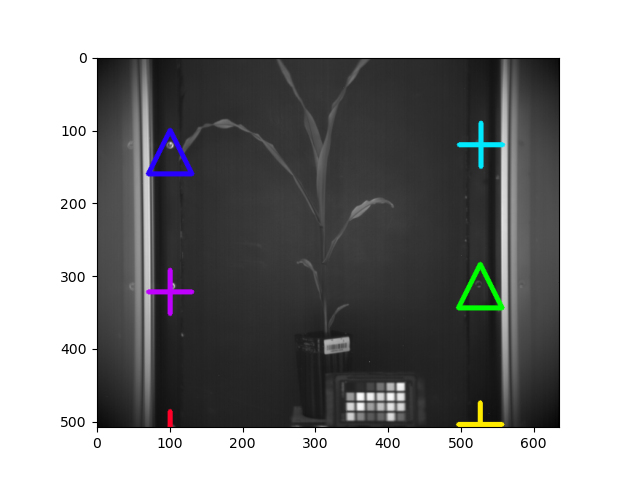

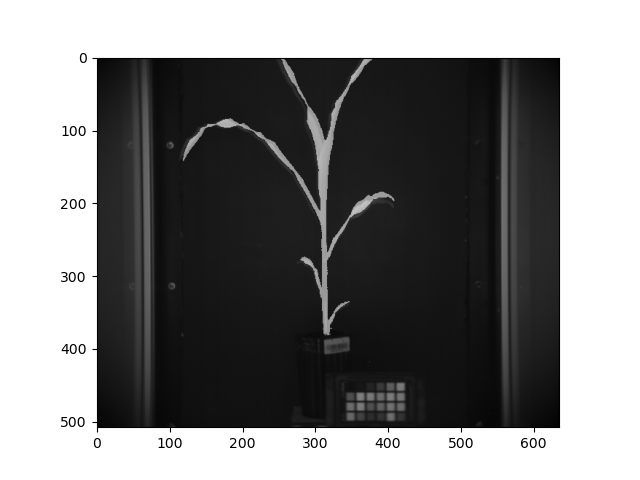

In [12]:
# Apply landmark transformation (we chose to use the screws in the background) to align both images 
img_warped, mat = pcv.transform.warp(img=mask, refimg=nir,
                                     pts = [(500, 454), (1995, 454), (1995, 1136), (1984, 1811), (511, 1804), 
                                            (500, 1136)],
                                     refpts = [(100, 130), (527, 120), (526, 314), (526, 504), (100, 516), 
                                               (100, 322)],
                                     method='lmeds')

In [13]:
# Analyze NIR pixel intensity values of the plant
# changing the label here would separate results in the JSON output but complicate any CSV downstream
nir_hist = pcv.analyze.grayscale(gray_img=nir, labeled_mask=img_warped, bins=100, label="default")

alt.FacetChart(...)

In [14]:
# Make a histogram visualization 
nir_hist = pcv.visualize.histogram(img=nir, mask=img_warped, lower_bound=0, upper_bound=None, bins=50,
                                   title="Histogram of NIR signal intensity")

alt.Chart(...)

In [15]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis.
pcv.outputs.save_results(filename=args.result, outformat="json")